In [1]:
from ast import literal_eval

from matrepr import mdisplay
from torch import linalg

from koopmann import aesthetics
from koopmann.data import (
    DatasetConfig,
    create_data_loader,
    get_dataset_class,
)
from koopmann.models import MLP, Autoencoder, ExponentialKoopmanAutencoder
from koopmann.models.utils import (
    pad_act,
    parse_safetensors_metadata,
)
from koopmann.utils import compute_model_accuracy
from koopmann.visualization import plot_eigenvalues

%load_ext autoreload
%autoreload 2

In [2]:
model_name = "lotusroot_model"
scale_idx = "1"
k = "10"
dim = "20"

In [3]:
model_file_path = f"/home/nsa325/work/koopmann/model_saves/{model_name}.safetensors"
ae_file_path = (
    f"/scratch/nsa325/koopmann/k_{k}_dim_{dim}_loc_{scale_idx}_autoencoder_{model_name}.safetensors"
)

In [4]:
# Dataset config
metadata = parse_safetensors_metadata(file_path=model_file_path)
dataset_config = DatasetConfig(
    dataset_name=metadata["dataset"],
    num_samples=5_000,
    split="test",
    seed=21,
)
DatasetClass = get_dataset_class(name=dataset_config.dataset_name)
dataset = DatasetClass(config=dataset_config)
dataloader = create_data_loader(dataset, batch_size=1024)

In [5]:
model, _ = MLP.load_model(model_file_path)
model.eval()
model.hook_model()
print(f"Testing Accuracy: {compute_model_accuracy(model.to('cpu'), dataset)}")


Testing Accuracy: 0.9602000117301941


In [6]:
# autoencoder, metadata = Autoencoder.load_model(ae_file_path)
autoencoder, metadata = ExponentialKoopmanAutencoder.load_model(ae_file_path)
autoencoder.eval()
k = literal_eval(metadata["num_scaled"])
print(f"Little K: {k}")

Little K: 10


(<Figure size 400x400 with 1 Axes>, <Axes: xlabel='None', ylabel='None'>)

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


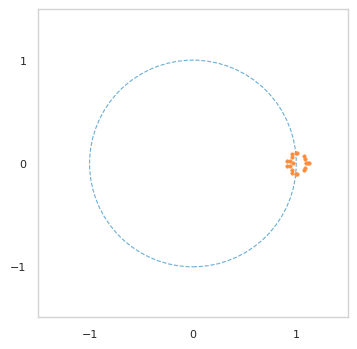

In [7]:
eigenvalues, eigenvectors = linalg.eig(autoencoder.koopman_matrix.linear_layer.weight.detach())
plot_eigenvalues(
    eigenvalues=eigenvalues,
    tile_size=4,
)

In [8]:
batch = next(iter(dataloader))

First layer

In [9]:
model.forward(batch[0])
acts = model.get_fwd_activations()
mdisplay(acts[0][0])

0,1,2,3,4,5,6,7,8,9
0.0000,0.0000,1.1355,0.0000,0.1457,0.0000,1.7070,0.0000,0.7226,0.0000


In [10]:
recons = autoencoder(
    x=pad_act(acts[0], target_size=autoencoder.encoder[0].in_features), k=0
).reconstruction
mdisplay(recons[0])
print((recons - acts[0]).pow(2).mean())

0,1,2,3,4,5,6,7,8,9
0.4997,-0.1812,0.3284,0.3979,-0.2017,0.2254,0.0535,-0.2617,-0.2266,0.4016


tensor(0.3790, grad_fn=<MeanBackward0>)


Last layer

In [11]:
mdisplay(acts[4][0])

0,1
2.1561,-2.4993


In [12]:
all_pred = autoencoder(
    x=pad_act(acts[0], target_size=autoencoder.encoder[0].in_features), k=k
).predictions
pred = all_pred[k, :, : acts[4].size(-1)]
mdisplay(pred[0])
print((pred - acts[4]).pow(2).mean())

0,1
3.0438,-1.9242


tensor(15.7178, grad_fn=<MeanBackward0>)


In [13]:
recons = autoencoder(
    x=pad_act(acts[4], target_size=autoencoder.encoder[0].in_features), k=0
).reconstruction[:, : acts[4].size(-1)]
mdisplay(recons[0])
print((recons - acts[4]).pow(2).mean())

0,1
1.2766,-0.5237


tensor(9.2889, grad_fn=<MeanBackward0>)
